A Natural Language Processing project that aims to classify twitter sentiments as negative or positive.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import string
import re
import os
import warnings
warnings.filterwarnings("ignore")


## DATA MUNGING

In [2]:
#import stop words
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/ezzy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ezzy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ezzy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#file path
file_path = "/home/ezzy/Desktop/repos/Text-classifier/judge-1377884607_tweet_product_company.csv"
#using os to access the file using the path
path = os.path.join(file_path)
#list of different types of encodings
encodings = ["utf-8", "latin1", "iso-8859-1", "cp1252"]
#looping through the list and creating a DataFrame 
for encode in encodings:
    try:
        tweet_df = pd.read_csv(path, encoding= encode)
        print(f"File read successfully with encoding: {encode}")
        break
    except: UnicodeDecodeError 
    print(f"Failed to read file with encoding {encode}: ")

Failed to read file with encoding utf-8: 
File read successfully with encoding: latin1


##### Inspecting our data 
* Look at how the DataFrame looks like(how many rows and columns are there?)
* Checking for null values
* Checking if duplicates are there

In [4]:
tweet_df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


Looking at the head and tail of the DataFrame we can see that we have three columns namely; `tweet_text`- consists of the username and his or her sentiment, `emotion_in_tweet_is_directed_at`- product at which the sentiment is based on, `is_there_an_emotion_directed_at_a_brand_or_product`- emotion based on the user's sentiment classified into positive, negative and no emotion toward brand or product. The DataFrame has 9093 records.

In [5]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The info of the DataFrame tells us the `tweet_text` column has 1 missing value, `emotion_in_tweet_is_directed_at` has the highest missing values with a record of 5802 missing records and `is_there_an_emotion_directed_at_a_brand_or_product` with no missing record. We can also see the data types we are working with are objects which in our case are strings 

In [6]:
tweet_df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


From the descriptive statistics we see that all tweets are unique meaning that no user's tweeted the same thing. The most tweeted product is `ipad` and the most common emotion directed towards the product is `No emotion toward brand or product`.
#### Dealing with null values
We have two columns having nan values in there records. To deal with this problem, I will either drop the nan values or impute them using the mode since we are generally using categorical data. `emotion_in_tweet_is_directed_at` column has 5803 records missing that is almost 63.81% of missing data. This will be hard to impute because almost half the data is missing and also imputing such a huge number of missing values can lead to miscommunication from the data and we can end up making wrong decisions or gaining wrong insights. The `tweet_text` column also has one missing value and since these are unique tweets from different users we will drop the nan value.

In [7]:
tweet_df = tweet_df.dropna(subset=["tweet_text"])

In [8]:
tweet_df["tweet_text"].isna().sum()

0

#### Text preprocessing

This involves;
* Removing stop words(a, an, and, that etc) - words that appear many times in our text but has low semantic value or meaning.
* Removing punctuation- hyphens, fullstops, hashtags, parenthesis
* Lowering all the words
* Removing words that are not in the vocabulary(i.e usernames)
* Stemming and Lemmatization of text
I will utilize NLTk to perform the above steps

In [9]:
#function to help us preprocess our text using regex
def pattern_remover(text, pattern):
    rem = re.findall(pattern, text)
    
    for word in rem:
        
        text = re.sub(word, "", text)
        
    return text

Removing user names from the sentiments.

In [10]:
#removing usernames
tweet_df["cleaned"] = np.vectorize(pattern_remover)(tweet_df["tweet_text"], "@[\w]*")

In [11]:
tweet_df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,. I have a 3G iPhone. After 3 hrs tweeting at ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Know about ? Awesome iPad/iPhone app that yo...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Can not wait for #iPad 2 also. They should sa...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,I hope this year's festival isn't as crashy a...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff on Fri #SXSW: Marissa Mayer (Goog...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Ipad everywhere. #SXSW {link}
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,"Wave, buzz... RT We interrupt your regularly ..."
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,"Google's Zeiger, a physician never reported po..."
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,Some Verizon iPhone customers complained their...


Our new column has clean tweets that do not have the @username part. Next I am going to remove punctuations, and numerals.

In [12]:
#removing punctuations and numeric characters
tweet_df["cleaned"] = tweet_df["cleaned"].str.replace("[^a-zA-Z]", " ", regex= True)
#head of df
tweet_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,I have a G iPhone After hrs tweeting at ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Know about Awesome iPad iPhone app that yo...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Can not wait for iPad also They should sa...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,I hope this year s festival isn t as crashy a...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff on Fri SXSW Marissa Mayer Goog...


Our tweets now are in a good format since we have removed the numerals and punctuation(except space). Next I am going to tokenize the tweets, lower all the characters and remove stop words.

In [13]:
#stopwords in english
stopwords_list  = stopwords.words('english')

#tokenizing the text
tweet_df["cleaned"] = tweet_df["cleaned"].apply(lambda x: word_tokenize(x, language= "english"))
#removing stopwords from the tokenized strings
tweet_df["cleaned"] = tweet_df["cleaned"].apply(lambda tokens: [w.lower() for w in tokens if w.lower() not in stopwords_list])

tweet_df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[g, iphone, hrs, tweeting, rise, austin, dead,..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[know, awesome, ipad, iphone, app, likely, app..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, iphone, a..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[great, stuff, fri, sxsw, marissa, mayer, goog..."
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,"[ipad, everywhere, sxsw, link]"
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,"[wave, buzz, rt, interrupt, regularly, schedul..."
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,"[google, zeiger, physician, never, reported, p..."
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,"[verizon, iphone, customers, complained, time,..."


Our tweets are now tokenized, are in small letters and all stop words have been eliminated. My next step is to stem or lemmatize the tweets; such that a word like complained will be reduced to complain

In [14]:
#instantiating wnl 
lemmatizer = WordNetLemmatizer()
#applying to the tokenized tweets
tweet_df["cleaned"] = tweet_df["cleaned"].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

In [15]:
tweet_df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[g, iphone, hr, tweeting, rise, austin, dead, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[know, awesome, ipad, iphone, app, likely, app..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[hope, year, festival, crashy, year, iphone, a..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[great, stuff, fri, sxsw, marissa, mayer, goog..."
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,"[ipad, everywhere, sxsw, link]"
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,"[wave, buzz, rt, interrupt, regularly, schedul..."
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,"[google, zeiger, physician, never, reported, p..."
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,"[verizon, iphone, customer, complained, time, ..."


In [16]:
e = lemmatizer.lemmatize("complained", pos= "n")
e

'complained'

#### Exploratory Data Analysis(EDA)
Exploratory Data Analysis (EDA) is an approach to analyze and summarize datasets to understand the underlying patterns and trends visually.


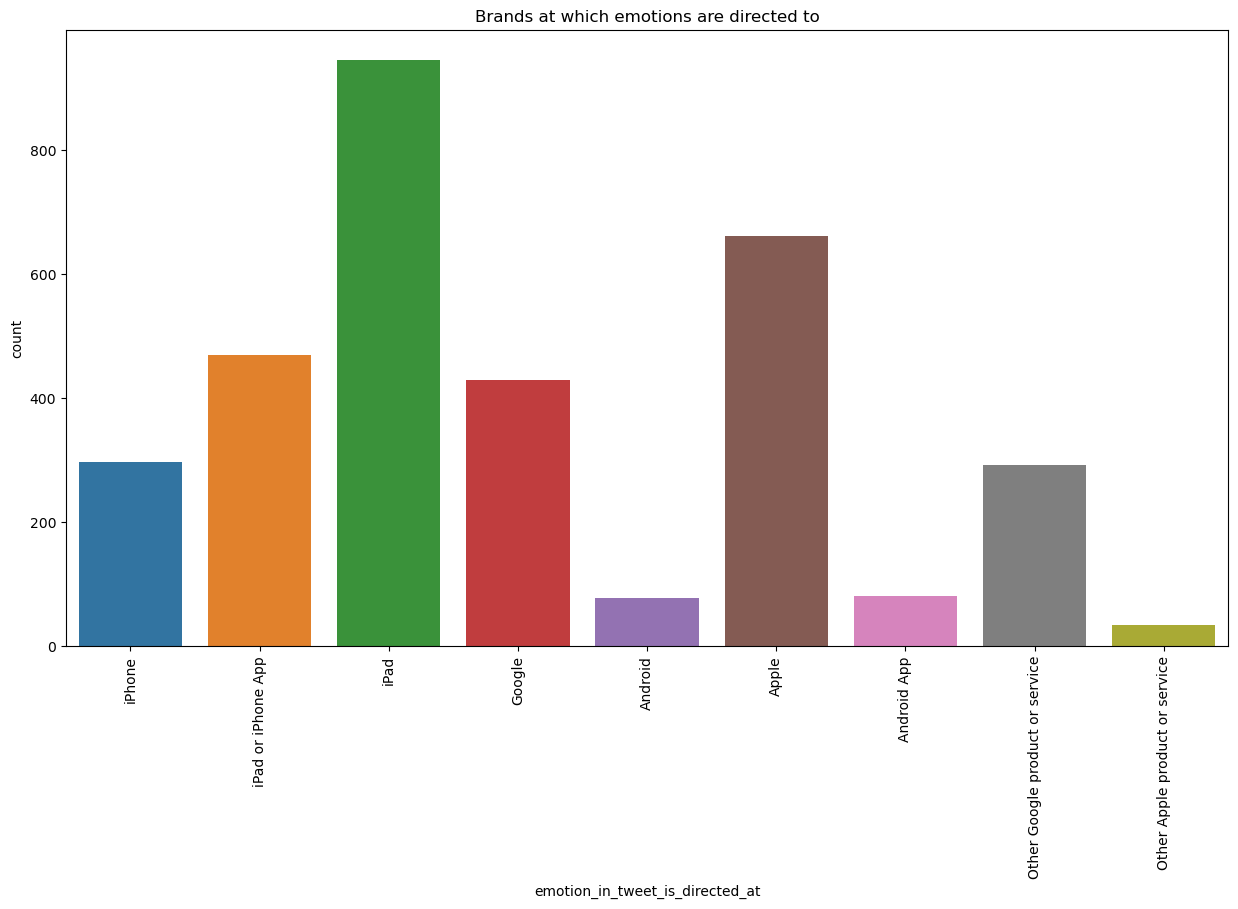

In [20]:
plt.figure(figsize=(15, 8))
sns.countplot(data= tweet_df, x= tweet_df["emotion_in_tweet_is_directed_at"])
plt.title("Brands at which emotions are directed to")
plt.xticks(rotation = 90)
plt.show();

We have nine brands being tweeted about by users. `ipad` has the highest tweets with over 800 mentions. We can see also that other `Apple` products top the chart such as `iphone`, `iphone app`, and `apple` itself. `Google` comes in second together with its other google products or services. `Other Apple prodiuct or service` is the least mentioned in the tweets.